<a href="https://colab.research.google.com/github/rhiga2/DeepLearningHawaii/blob/main/workshops/transformers_and_gpt/TransformerModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch
!pip install matplotlib
!pip install pytorch_lightning
!pip install transformers
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 8.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 76.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [15]:
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM

# Introduction to Transformers and GPT

## Tokenization

In [19]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')

In [17]:
text = "What can I do with transformers?"
tokens = tokenizer(text)
print(tokens)
print(tokenizer.convert_ids_to_tokens(tokens['input_ids']))

{'input_ids': [2061, 460, 314, 466, 351, 6121, 364, 30], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}
['What', 'Ġcan', 'ĠI', 'Ġdo', 'Ġwith', 'Ġtransform', 'ers', '?']


In [18]:
encoded_input = tokenizer(text, return_tensors='pt').to(device)
print(encoded_input)

{'input_ids': tensor([[2061,  460,  314,  466,  351, 6121,  364,   30]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}


## Text and Positional Embeddings

In [20]:
# What's inside GPT-2?
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = AutoModelForCausalLM.from_pretrained('gpt2').to(device)
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [22]:
text = "dog cat tiger wolf lion puppy kitten"
tokens = tokenizer(text)
print(tokenizer.convert_ids_to_tokens(tokens['input_ids']))
encoded_input = tokenizer(text, return_tensors='pt').to(device)
encodings = model.transformer.wte(encoded_input['input_ids'])
print(encodings.size())

['dog', 'Ġcat', 'Ġtiger', 'Ġwolf', 'Ġlion', 'Ġpuppy', 'Ġkitten']
torch.Size([1, 7, 768])


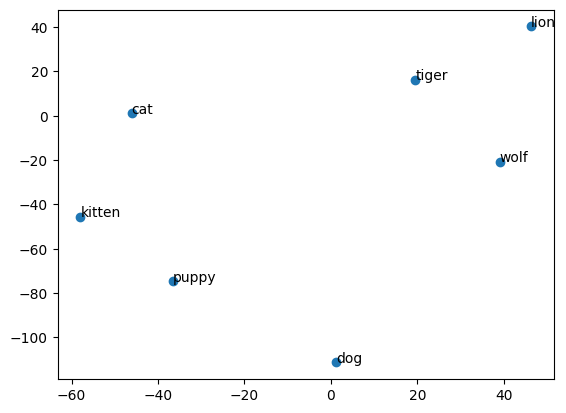

In [23]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity = 3)
word_embeddings = tsne.fit_transform(encodings.squeeze(0).detach().to('cpu'))
words = text.split(' ')

fig, ax = plt.subplots()
ax.scatter(word_embeddings[:, 0], word_embeddings[:, 1])
for i, word in enumerate(words):
  ax.annotate(word, (word_embeddings[i, 0], word_embeddings[i, 1]))

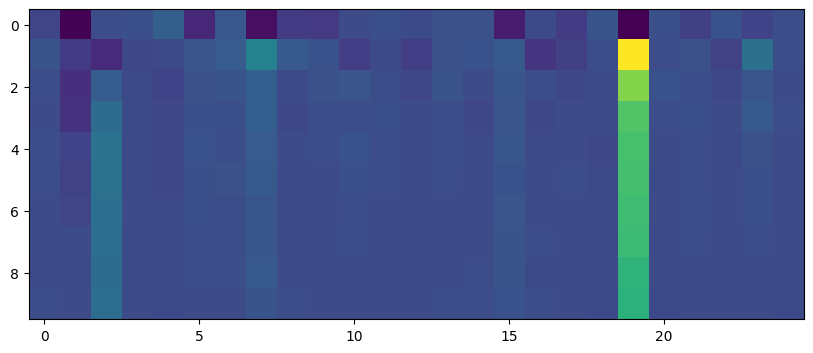

In [25]:
positional_encodings = model.transformer.wpe(torch.IntTensor(np.arange(0, 10)).to(device))[:, 0:25]
plt.figure(figsize = (10, 10))
plt.imshow(positional_encodings.squeeze(0).detach().to('cpu'))

## Softmax and Attention

<BarContainer object of 4 artists>

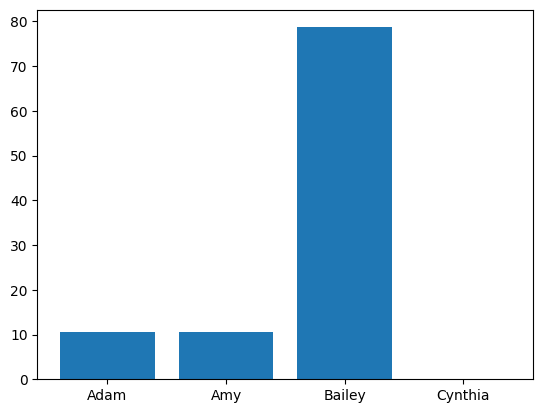

In [26]:
def softmax(data, T = 1):
  exp_data = np.exp(data / T)
  return exp_data / np.sum(exp_data) 

names = ['Adam', 'Amy', 'Bailey', 'Cynthia']
money_made = np.array([10, 10, 12, -20])
bonuses = 100 * softmax(money_made, T = 1)
plt.bar(names, bonuses)

## OutPutting it All Together

In [58]:
text = "Deep learning is a field of AI that is"
tokens = tokenizer(text)
input_ids = tokenizer(text, return_tensors='pt')['input_ids'].to(device)
n_steps = 8
choices_per_word = 5

with torch.no_grad():
  for i in range(n_steps): 
    iteration = {}
    iteration['Input'] = tokenizer.decode(input_ids[0])
    logits = model(input_ids = input_ids).logits[0, -1, :]
    probs = torch.softmax(logits, dim = -1)
    best_tokens = torch.argsort(probs, dim = -1, descending = True)
    print(tokenizer.decode(input_ids[0]))
    for choice_idx in range(choices_per_word):
      token_id = best_tokens[choice_idx]
      word = tokenizer.decode(token_id)
      prob = probs[choice_idx]
      print(f'Choice {choice_idx}: ', word)
    input_ids = torch.cat([input_ids, best_tokens[None, 0, None]], dim = -1) 

Deep learning is a field of AI that is
Choice 0:   currently
Choice 1:   being
Choice 2:   not
Choice 3:   rapidly
Choice 4:   very
Deep learning is a field of AI that is currently
Choice 0:   being
Choice 1:   in
Choice 2:   under
Choice 3:   undergoing
Choice 4:   dominated
Deep learning is a field of AI that is currently being
Choice 0:   explored
Choice 1:   studied
Choice 2:   developed
Choice 3:   used
Choice 4:   pursued
Deep learning is a field of AI that is currently being explored
Choice 0:   by
Choice 1:   in
Choice 2:   and
Choice 3:   for
Choice 4:  .
Deep learning is a field of AI that is currently being explored by
Choice 0:   many
Choice 1:   researchers
Choice 2:   the
Choice 3:   a
Choice 4:   some
Deep learning is a field of AI that is currently being explored by many
Choice 0:   companies
Choice 1:   researchers
Choice 2:   different
Choice 3:   universities
Choice 4:   of
Deep learning is a field of AI that is currently being explored by many companies
Choice 0:  .